<a href="https://colab.research.google.com/github/chitra-psg/rossmann_sales_prediction/blob/main/Rossman_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [2]:
store = pd.read_csv('store.csv')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [3]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [4]:
#Check nulls for null treatment
store.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [5]:
#Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
store.Promo2.value_counts()

1    571
0    544
Name: Promo2, dtype: int64

In [6]:
#CompetitionDistance - describes thedistance in meters to the nearest competitor store
store[store['CompetitionDistance'].isna()]
#Competition Distance not available would indicate no competitor

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [9]:
#NULL Treatment
#Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
#PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew.
#E.g. "Feb, May, Aug, Nov" means each round starts in February, May, August, November of any given year for that store
store['Promo2SinceWeek'] = store['Promo2SinceWeek'].replace(np.nan,0).astype(int)
store['Promo2SinceYear'] = store['Promo2SinceYear'].replace(np.nan,0).astype(int)
store['PromoInterval'] = store['PromoInterval'].replace(np.nan,0)

#CompetitionDistance - describes the distance in meters to the nearest competitor store
#CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

store['CompetitionDistance'] = store['CompetitionDistance'].replace(np.nan,0).astype(int)
store['CompetitionOpenSinceMonth'] = store['CompetitionOpenSinceMonth'].fillna(store['CompetitionOpenSinceMonth'].mode()[0]).astype(int)
store['CompetitionOpenSinceYear'] = store['CompetitionOpenSinceYear'].fillna(store['CompetitionOpenSinceYear'].mode()[0]).astype(int)

In [10]:

store[store['CompetitionDistance']==0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,0,9,2013,0,0,0,0
621,622,a,c,0,9,2013,0,0,0,0
878,879,d,a,0,9,2013,1,5,2013,"Feb,May,Aug,Nov"


In [11]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270,9,2008,0,0,0,0
1,2,a,a,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,c,c,620,9,2009,0,0,0,0
4,5,a,a,29910,4,2015,0,0,0,0


In [41]:
# Doing competition month and year = 0
store.loc[store.CompetitionDistance==0, 'CompetitionOpenSinceMonth'] = 0
store.loc[store.CompetitionDistance==0, 'CompetitionOpenSinceYear'] = 0

In [42]:

store[store['CompetitionDistance']==0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,0,0,0,0,0,0,0
621,622,a,c,0,0,0,0,0,0,0
878,879,d,a,0,0,0,1,5,2013,"Feb,May,Aug,Nov"


In [12]:
store.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

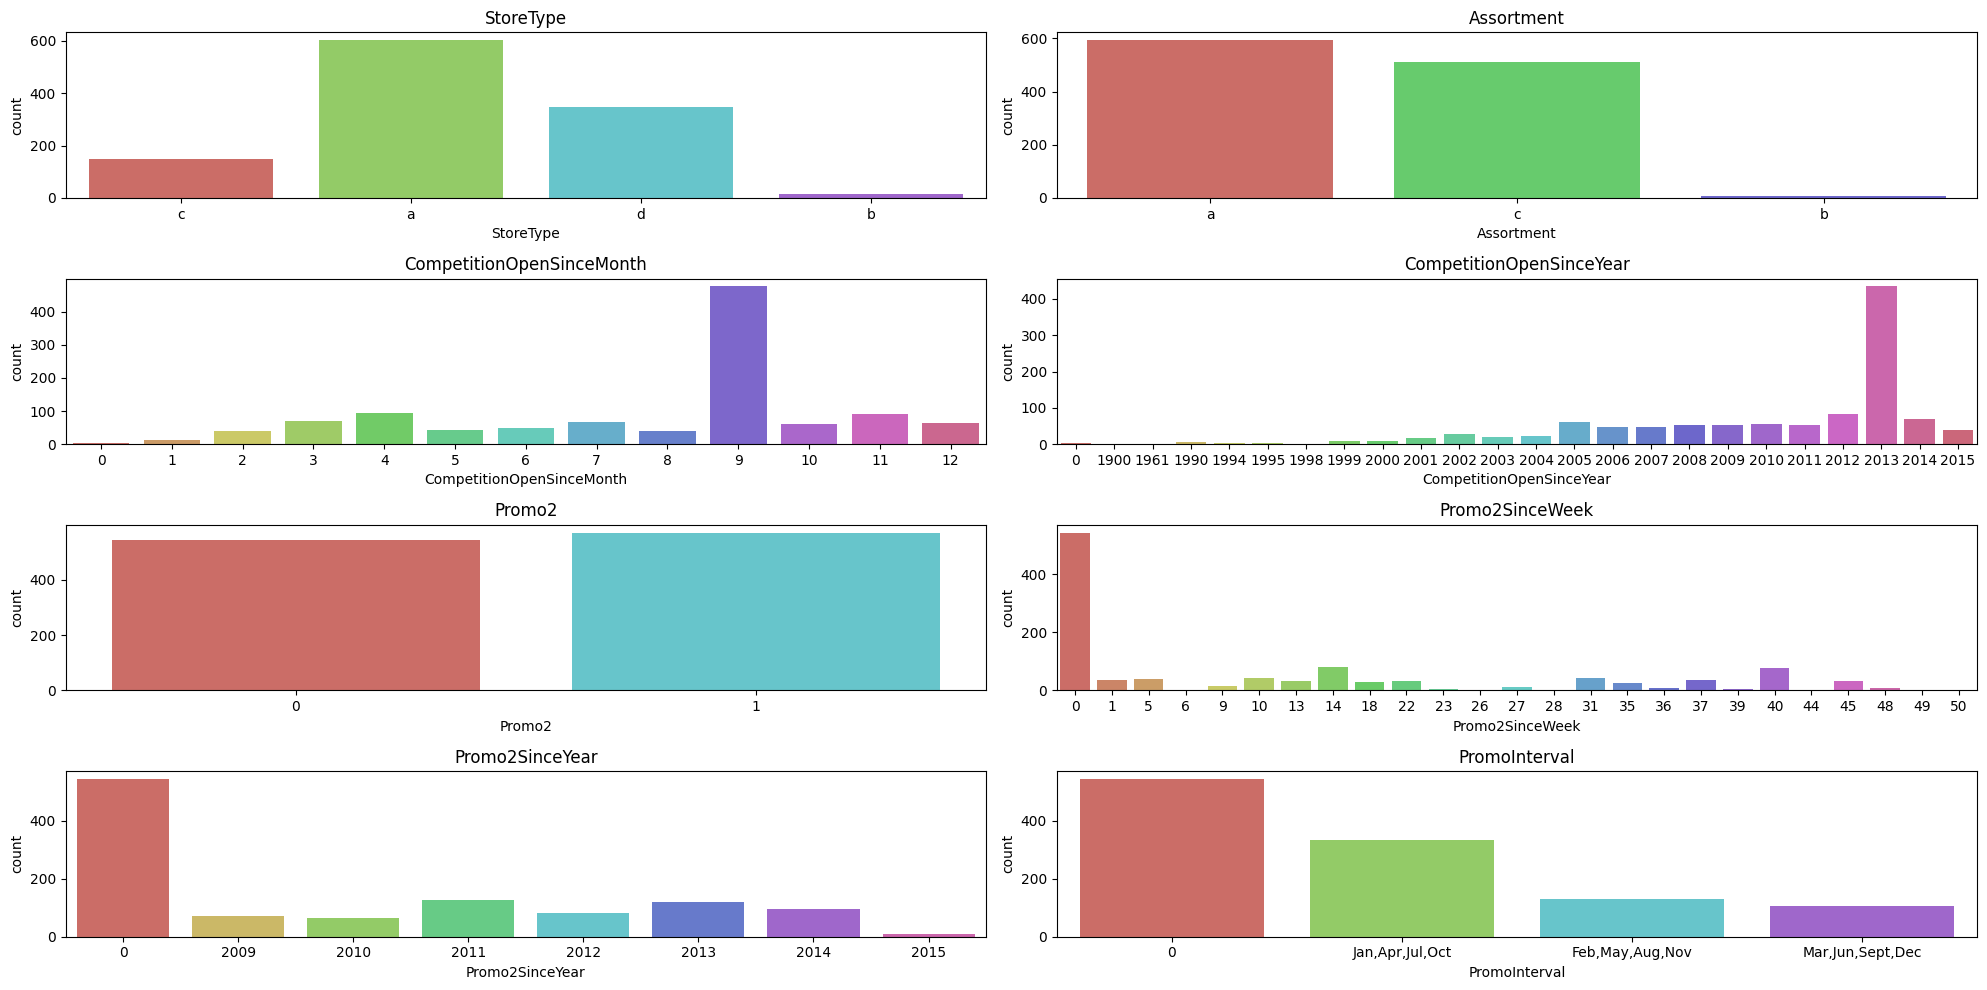

In [43]:
# Select categorical columns
categorical_cols = ['StoreType', 'Assortment','CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']#Excluding Store

# Define rows and columns for subplots
rows = int(np.ceil(len(categorical_cols) / 2))  # Assuming 3 columns per row
cols = min(2, len(categorical_cols))

# Create figure and subplots
fig, axs = plt.subplots(rows, cols, figsize=(20, 10), squeeze=True)  # Ensure 1D array of subplots

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=store, ax=axs.ravel()[i], palette="hls")
    axs.ravel()[i].set_title(col)
    axs.ravel()[i].xaxis.set_label_text(col)  # Access and set label on the correct subplot's axis

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()


**Inferences**
> Maximum competitions are opened in the month of september or 9

> Maximum competitiors opened their store in the year 2013

> 48% stores don't have promo2

> StoreType = a is maximum among others

> Majority of assortments are 'a'





In [55]:
train_df = pd.read_csv('train.csv')
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [56]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [58]:
train_df['Date'] = pd.to_datetime(train_df.Date, format='%Y-%m-%d')

train_df = train_df.set_index('Date')

In [59]:
train_df.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [60]:
train_df.StateHoliday = train_df.StateHoliday.replace('0',0)

In [61]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 69.8+ MB
